In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=60,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


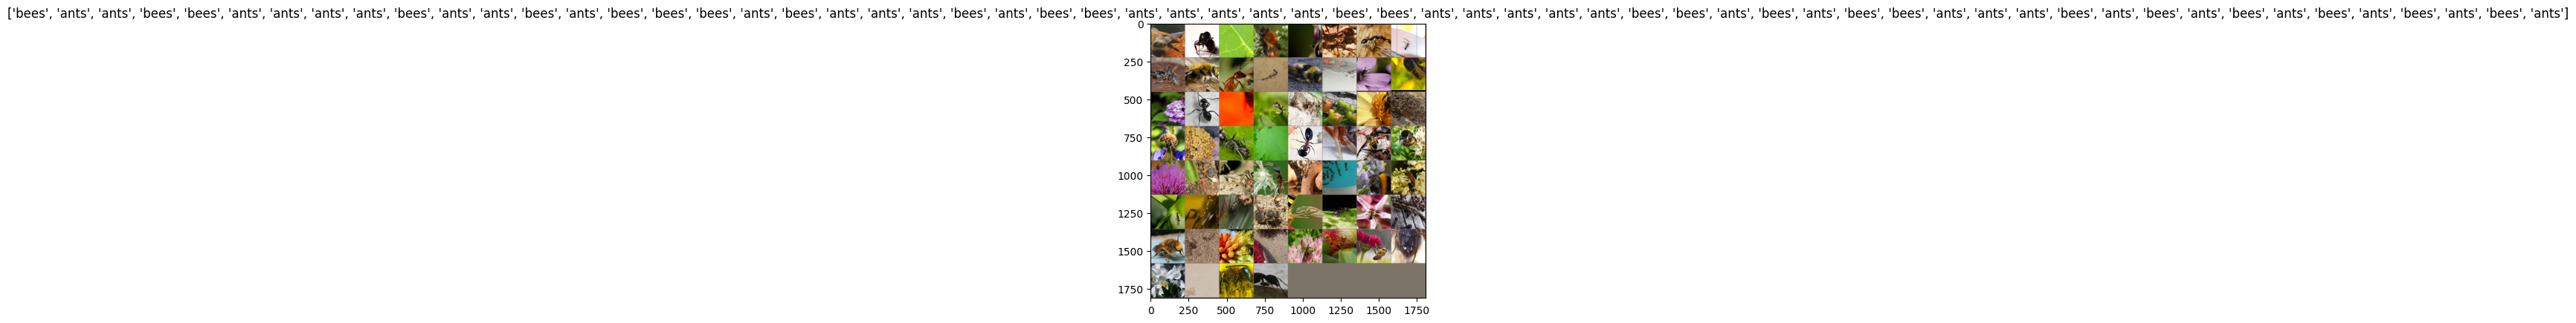

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Reference
---------------------
[Transfer Learning for Computer Vision Tutorial],
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`,
`cs231n notes <https://cs231n.github.io/transfer-learning/>`


## Model Setup and Training

In [5]:
# Load pretrained ResNet model and modify for our binary classification
def setup_model():
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: bees and ants
    model = model.to(device)
    return model

In [14]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    model.load_state_dict(best_model_wts)
    return model

In [15]:
# Set up the model and training parameters
model = setup_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
# Train the model
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.7304 Acc: 0.5164
val Loss: 0.6254 Acc: 0.6078

Epoch 2/10
----------
train Loss: 0.6015 Acc: 0.6516
val Loss: 0.4518 Acc: 0.8366

Epoch 3/10
----------
train Loss: 0.4596 Acc: 0.8279
val Loss: 0.3703 Acc: 0.8889

Epoch 4/10
----------
train Loss: 0.3581 Acc: 0.8893
val Loss: 0.2939 Acc: 0.8889

Epoch 5/10
----------
train Loss: 0.3342 Acc: 0.8443
val Loss: 0.2600 Acc: 0.9020

Epoch 6/10
----------
train Loss: 0.2434 Acc: 0.9303
val Loss: 0.1965 Acc: 0.9412

Epoch 7/10
----------
train Loss: 0.2113 Acc: 0.9262
val Loss: 0.1829 Acc: 0.9477

Epoch 8/10
----------
train Loss: 0.1826 Acc: 0.9549
val Loss: 0.1827 Acc: 0.9477

Epoch 9/10
----------
train Loss: 0.1911 Acc: 0.9344
val Loss: 0.1791 Acc: 0.9542

Epoch 10/10
----------
train Loss: 0.2135 Acc: 0.9057
val Loss: 0.1854 Acc: 0.9542



## Perturbation Window Function

A function that applies the sliding perturbation window to an image -

In [17]:
def apply_perturbation_window(image, window_size, stride):
    """
    Apply a sliding perturbation window over the image and get predictions.

    Args:
        image (torch.Tensor): Input image tensor (C x H x W)
        window_size (int): Size of the square perturbation window
        stride (int): Step size for sliding the window

    Returns:
        numpy.ndarray: Heatmap of prediction values
    """
    image = image.to(device)
    model.eval()

    # Get image dimensions
    _, height, width = image.shape

    # Calculate output heatmap dimensions
    h_out = (height - window_size) // stride + 1
    w_out = (width - window_size) // stride + 1

    heatmap = np.zeros((h_out, w_out))

    # Slide window over image
    for i in range(h_out):
        for j in range(w_out):
            # Create a copy of the image
            perturbed_image = image.clone()

            # Apply perturbation window
            h_start = i * stride
            w_start = j * stride
            perturbed_image[:, h_start:h_start+window_size,
                          w_start:w_start+window_size] = 0

            # Get prediction
            with torch.no_grad():
                output = model(perturbed_image.unsqueeze(0))
                prob = torch.softmax(output, dim=1)[0]
                heatmap[i, j] = prob[1].item()  # Probability for class 1

    return heatmap

In [18]:
#  function to visualize the original image and its corresponding heatmap
def plot_results(image, heatmap, window_size):
    plt.figure(figsize=(12, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    imshow(image, title='Original Image')

    # Plot heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Prediction Heatmap (Window Size: {window_size}x{window_size})')
    plt.show()

In [21]:
def plot_perturbation_results(image, window_sizes, stride):
    """
    Plot original image and perturbation heatmaps with better spacing and clarity.
    """
    # Create figure with more space between subplots
    plt.figure(figsize=(20, 5))

    # Plot original image
    plt.subplot(1, len(window_sizes) + 1, 1)
    img_display = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)
    plt.imshow(img_display)
    plt.title('Original Image', fontsize=12, pad=10)
    plt.axis('off')

    # Generate and plot heatmaps for different window sizes
    for idx, window_size in enumerate(window_sizes):
        # Apply perturbation window
        heatmap = apply_perturbation_window(image, window_size, stride)

        # Plot heatmap
        plt.subplot(1, len(window_sizes) + 1, idx + 2)
        im = plt.imshow(heatmap, cmap='YlOrRd', interpolation='nearest')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.title(f'Window Size: {window_size}x{window_size}', fontsize=12, pad=10)
        plt.axis('on')
        plt.grid(True, alpha=0.3)

    plt.tight_layout(w_pad=3.0)  # Increase spacing between subplots
    plt.show()

## Run Analysis with Different Window Sizes

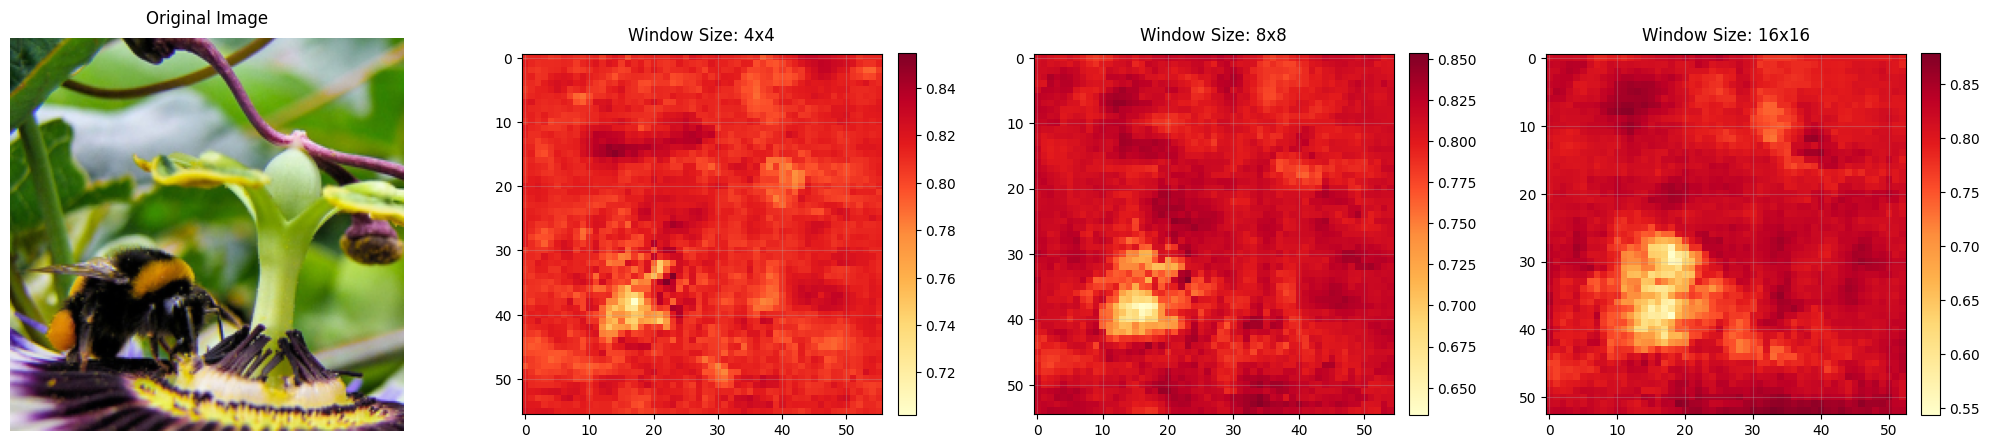

In [28]:
# Get a test image
test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=True)
test_images, test_labels = next(iter(test_loader))
test_image = test_images[0]

# Try different window sizes
window_sizes = [4, 8, 16]
stride = 4  # You can adjust this for different granularity

# Plot results
plot_perturbation_results(test_image, window_sizes, stride)

- **4x4 Window**: Shows high sensitivity across the image with particular focus on the bee area
- **8x8 Window**: Stronger contrast between important and less important regions, clearly highlighting the bee
- **16x16 Window**: Most consolidated view, showing very high sensitivity (0.55-0.85) around the bee's location